In [1]:
#| export

from pathlib import Path
from random import randrange, choice, sample
from typing import List, Any
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import dask.dataframe as dd

In [2]:
from infobip_service.download import raw_data_path

In [3]:
#| export

processed_data_path = Path() / '..' / 'data' / 'processed'

In [4]:
processed_data_path.mkdir(parents=True, exist_ok=True)

In [5]:
raw_data = dd.read_parquet(raw_data_path)
raw_data.head()

,AccountId,ApplicationId,DefinitionId,OccurredTime,OccurredTimeTicks
PersonId,,,,,
0,12344,,personCreated,2023-05-22 13:47:04,1684763224886
0,12344,,personEnteredFlow,2023-05-22 14:19:33,1684765173309
0,12344,,personExitedFlow,2023-05-22 15:19:56,1684768796388
0,12344,,personEnteredFlow,2023-05-24 09:07:48,1684919268908
0,12344,,personExitedFlow,2023-05-24 10:08:16,1684922896648


## Time tresholding

In [6]:
def _sample_time_map(df: pd.DataFrame, *, time_treshold: datetime) -> pd.DataFrame:
    df = df[df['OccurredTime'] < time_treshold]
    return df

In [7]:
raw = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-10 13:27:01.246912",
            "2023-07-12 13:27:02.370368",
            "2023-07-12 13:27:03.493824",
            "2023-07-12 13:27:04.617280",
            "2023-07-10 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two", "three"],
        "ApplicationId": [None, None, None, None, None, None],
    }, index=pd.Index([1, 2, 2, 3, 3, 3], name="PersonId"))
raw["OccurredTime"] = pd.to_datetime(raw["OccurredTime"])
raw["DefinitionId"] = raw["DefinitionId"].astype("string[pyarrow]")
raw["ApplicationId"] = raw["ApplicationId"].astype("string[pyarrow]")


expected = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-10 13:27:01.246912",
            "2023-07-10 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "three"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 2, 3], name="PersonId"))
expected["OccurredTime"] = pd.to_datetime(expected["OccurredTime"])
expected["DefinitionId"] = expected["DefinitionId"].astype("string[pyarrow]")
expected["ApplicationId"] = expected["ApplicationId"].astype("string[pyarrow]")

In [8]:
pd.testing.assert_frame_equal(_sample_time_map(raw, time_treshold=datetime(2023, 7, 11)), expected)

In [9]:
#| export

def sample_time_map(ddf: dd.DataFrame, *, time_treshold: datetime) -> dd.DataFrame:
    meta = _sample_time_map(ddf._meta, time_treshold=time_treshold)
    return ddf.map_partitions(_sample_time_map, time_treshold=time_treshold, meta=meta)

In [10]:
actual = sample_time_map(dd.from_pandas(raw, npartitions=2), time_treshold=datetime(2023, 7, 11)).compute()
pd.testing.assert_frame_equal(actual, expected)

### Dataset time exploration

In [11]:
time_stats = raw_data["OccurredTime"].describe().compute()
time_stats

count                         27999602
min                2023-03-29 12:59:30
25%                2023-06-15 10:01:10
50%                2023-10-17 13:10:22
75%      2023-11-28 08:59:49.321999872
max         2023-12-23 00:00:30.906000
Name: OccurredTime, dtype: string

In [12]:
# | export

# Time treshold is 56 days before the latest event. 28 days before for test horizon and 28 days more for train/validation horizon
max_time = datetime.strptime(time_stats["max"], "%Y-%m-%d %H:%M:%S.%f")
time_treshold = max_time - timedelta(days=56)
time_treshold

datetime.datetime(2023, 10, 28, 0, 0, 30, 906000)

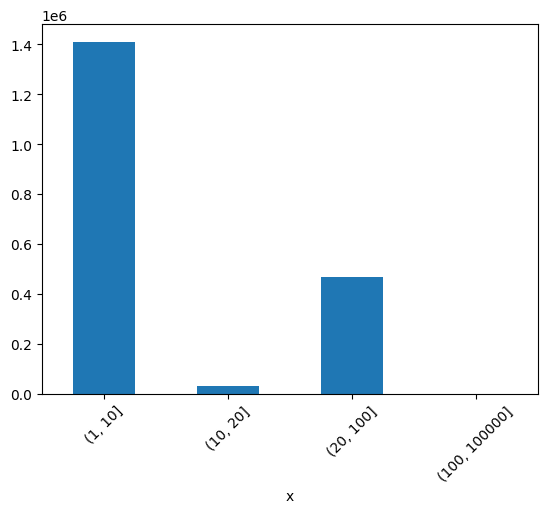

In [13]:
df = pd.DataFrame({'x':sample_time_map(raw_data, time_treshold=time_treshold).index.value_counts().compute().values})
factor = pd.cut(df.x, [1,10,20,100,100000])
df.groupby(factor).apply(lambda x: x.count()).plot(kind='bar', rot=45, legend=0);

# Sample construction

## Next event

In [14]:
def _get_next_event(df: pd.DataFrame, *, t0: datetime) -> pd.DataFrame:
    _df = df[df['OccurredTime'] >= t0]
    return pd.DataFrame({
        "AccountId": [_df["AccountId"].values[0] if len(_df) > 0 else None],
        "DefinitionId": [_df["DefinitionId"].values[0] if len(_df) > 0 else None],
        "ApplicationId": [_df["ApplicationId"].values[0] if len(_df) > 0 else None],
        "OccurredTime": [_df["OccurredTime"].values[0] if len(_df) > 0 else None],
    }, index=pd.Index(['NextEvent'])).T

In [15]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [16]:
_get_next_event(user_history, t0=datetime(2023, 7, 19))
_get_next_event(user_history, t0=datetime(2023, 7, 29))

,NextEvent
AccountId,None
DefinitionId,None
ApplicationId,None
OccurredTime,None


In [17]:
def get_next_event(df: pd.DataFrame, *, t0: datetime) -> pd.DataFrame:
    try:
        return df.groupby("PersonId").apply(lambda x: _get_next_event(x, t0=t0))
    except KeyError:
        print(df)

In [18]:
get_next_event(user_history, t0=datetime(2023, 7, 19))
get_next_event(user_history, t0=datetime(2023, 7, 29))

NextEvent
PersonId                        
1        AccountId          None
         DefinitionId       None
         ApplicationId      None
         OccurredTime       None

## History construction

In [19]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [20]:
#| export
def pad_left(l: list, *, size: int) -> list:
    return np.pad(l, pad_width=(size-len(l),0), mode='empty')


def _create_user_history(user_history: pd.DataFrame, *, t0: datetime, history_size: int) -> pd.DataFrame:
    user_history = user_history[user_history['OccurredTime'] < t0]
    user_history = user_history.sort_values(by='OccurredTime', ascending=False)
    user_history = user_history.head(history_size)
    user_history = user_history.sort_values(by='OccurredTime')

    reconstructed_history = pd.DataFrame({
        "AccountId": pad_left(user_history["AccountId"].values, size=history_size),
        "DefinitionId": pad_left(user_history["DefinitionId"].values, size=history_size),
        "ApplicationId": pad_left(user_history["ApplicationId"].values, size=history_size),
        "OccurredTime": pad_left(user_history["OccurredTime"].values, size=history_size),
    }, index=pd.Index([f"h_{i}" for i in range(history_size)], name="HistoryId")).T

    return reconstructed_history

In [21]:
_create_user_history(user_history, t0=datetime(2023, 7, 13), history_size=3)

HistoryId,h_0,h_1,h_2
AccountId,1688995620123456000,12345,12345
DefinitionId,None,one,one
ApplicationId,None,None,None
OccurredTime,1970-01-01 00:00:00,2023-07-10 13:27:00.123456,2023-07-12 13:27:01.246912


In [22]:
user_histories = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
            "2023-07-13 13:27:01.246912",
            "2023-07-26 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two"],
        "ApplicationId": [None, None, None, None, None],
    }, index=pd.Index([1, 1, 1, 2, 2], name="PersonId"))
user_histories["OccurredTime"] = pd.to_datetime(user_histories["OccurredTime"])
user_histories["AccountId"] = user_histories["AccountId"].astype("string[pyarrow]")

user_histories

,AccountId,OccurredTime,DefinitionId,ApplicationId
PersonId,,,,
1,12345,2023-07-10 13:27:00.123456,one,None
1,12345,2023-07-12 13:27:01.246912,one,None
1,12345,2023-07-28 13:27:05.740736,one,None
2,12345,2023-07-13 13:27:01.246912,two,None
2,12345,2023-07-26 13:27:05.740736,two,None


In [23]:
# | export

def create_user_histories(user_histories: pd.DataFrame, *, t0: datetime, history_size: int) -> pd.DataFrame:
        return user_histories.groupby("PersonId").apply(lambda x: _create_user_history(x, t0=t0, history_size=history_size))



In [24]:
create_user_histories(user_histories, t0=datetime(2023, 7, 16), history_size=2)

HistoryId                                         h_0  \
PersonId                                                
1        AccountId                              12345   
         DefinitionId                             one   
         ApplicationId                           None   
         OccurredTime      2023-07-10 13:27:00.123456   
2        AccountId                               None   
         DefinitionId                            None   
         ApplicationId                           None   
         OccurredTime   1970-01-01 00:00:00.000000001   

HistoryId                                      h_1  
PersonId                                            
1        AccountId                           12345  
         DefinitionId                          one  
         ApplicationId                        None  
         OccurredTime   2023-07-12 13:27:01.246912  
2        AccountId                           12345  
         DefinitionId                          two  
         ApplicationId                        None  
         OccurredTime   2023-07-13 13:27:01.246912

## Dataset sampling

In [25]:
def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

In [26]:
assert datetime(2023, 7, 10) < random_date(datetime(2023, 7, 10), datetime(2023, 7, 28)) < datetime(2023, 7, 28)

In [27]:
def sample_user_histories(user_histories: pd.DataFrame, *, min_time: datetime, max_time: datetime, history_size: int) -> pd.DataFrame:    
    num_samples_to_go = len(user_histories) // history_size + 1

    user_histories_sample = None

    while num_samples_to_go > 0:
        t0 = random_date(min_time, max_time)
        filtered_index = user_histories[user_histories['OccurredTime'] < t0].index.unique()
        if len(filtered_index) == 0:
            continue
        
        chosen_user_history = user_histories.loc[choice(filtered_index)]
        next_event_timedelta = get_next_event(chosen_user_history, t0=t0)
        reconstructed_history = create_user_histories(chosen_user_history, t0=t0, history_size=history_size)
        reconstructed_history = pd.merge(reconstructed_history, next_event_timedelta, left_index=True, right_index=True)
        reconstructed_history.index = reconstructed_history.index.map(lambda x: (f'{x[0]}_{t0}', x[1]))

        if user_histories_sample is None:
            user_histories_sample = reconstructed_history
        else:
            user_histories_sample = pd.concat([user_histories_sample, reconstructed_history])
        
        num_samples_to_go -= 1

    return user_histories_sample

In [28]:
# može se patchat random date ovdje za test

user_histories_sample = sample_user_histories(user_histories, min_time=datetime(2023, 7, 9) , max_time=datetime(2023, 7, 20), history_size=2)
user_histories_sample

h_0  \
PersonId                                                             
2_2023-07-18 13:25:29 AccountId                               None   
                      DefinitionId                            None   
                      ApplicationId                           None   
                      OccurredTime   1970-01-01 00:00:00.000000001   
2_2023-07-16 17:01:37 AccountId                               None   
                      DefinitionId                            None   
                      ApplicationId                           None   
                      OccurredTime   1970-01-01 00:00:00.000000001   
1_2023-07-11 01:31:52 AccountId                               None   
                      DefinitionId                            None   
                      ApplicationId                           None   
                      OccurredTime   1970-01-01 00:00:00.000000001   

                                                            h_1  \
PersonId                                                          
2_2023-07-18 13:25:29 AccountId                           12345   
                      DefinitionId                          two   
                      ApplicationId                        None   
                      OccurredTime   2023-07-13 13:27:01.246912   
2_2023-07-16 17:01:37 AccountId                           12345   
                      DefinitionId                          two   
                      ApplicationId                        None   
                      OccurredTime   2023-07-13 13:27:01.246912   
1_2023-07-11 01:31:52 AccountId                           12345   
                      DefinitionId                          one   
                      ApplicationId                        None   
                      OccurredTime   2023-07-10 13:27:00.123456   

                                                      NextEvent  
PersonId                                                         
2_2023-07-18 13:25:29 AccountId                           12345  
                      DefinitionId                          two  
                      ApplicationId                        None  
                      OccurredTime   2023-07-26 13:27:05.740736  
2_2023-07-16 17:01:37 AccountId                           12345  
                      DefinitionId                          two  
                      ApplicationId                        None  
                      OccurredTime   2023-07-26 13:27:05.740736  
1_2023-07-11 01:31:52 AccountId                           12345  
                      DefinitionId                          one  
                      ApplicationId                        None  
                      OccurredTime   2023-07-12 13:27:01.246912

## Dataset preparation

Train/Validation prep:

1. Split into train/validation by PersonId (80/20)
2. Max time to max() of dataframe - 56
3. Min time to min() of dataframe
4. apply sample_user_histories to train and validation

Test prep:

2. Max time to max() of dataframe - 28
3. Min time to min() of dataframe
4. apply sample_user_histories to train and validation

In [29]:
def prepare_data(raw_data: dd.DataFrame, *, train_index: List[Any], validation_index: List[Any], min_time: datetime, max_time: datetime, history_size: int) -> pd.DataFrame:
    train_data = raw_data.loc[raw_data.index.isin(train_index)].repartition(partition_size="5MB")
    validation_data = raw_data.loc[raw_data.index.isin(validation_index)].repartition(partition_size="5MB")
    
    meta = sample_user_histories(train_data.head(2, npartitions=-1), min_time=min_time, max_time=max_time, history_size=history_size)    

    train_data = train_data.map_partitions(sample_user_histories, min_time=min_time, max_time=max_time, history_size=history_size, meta=meta)
    validation_data = validation_data.map_partitions(sample_user_histories, min_time=min_time, max_time=max_time, history_size=history_size, meta=meta)

    return train_data, validation_data

In [30]:
user_histories = pd.DataFrame({
        "AccountId": [12345, 12345, 12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
            "2023-07-13 13:27:01.246912",
            "2023-07-26 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one", "two", "two"],
        "ApplicationId": [None, None, None, None, None],
    }, index=pd.Index([1, 1, 2, 2, 2], name="PersonId"))
user_histories["OccurredTime"] = pd.to_datetime(user_histories["OccurredTime"])
user_histories["AccountId"] = user_histories["AccountId"].astype("string[pyarrow]")

user_histories_ddf = dd.from_pandas(user_histories, npartitions=2)
user_histories_ddf

,AccountId,OccurredTime,DefinitionId,ApplicationId
npartitions=2,,,,
1,string,datetime64[ns],string,string
2,...,...,...,...
2,...,...,...,...


In [31]:
user_index = user_histories_ddf.index.unique().compute()
train_index = np.random.choice(user_index, size=1, replace=False)
validation_index = np.setdiff1d(user_index, train_index)

max_time = datetime.strptime(user_histories_ddf["OccurredTime"].describe().compute()["max"], "%Y-%m-%d %H:%M:%S.%f")
min_time = datetime.strptime(user_histories_ddf["OccurredTime"].describe().compute()["min"], "%Y-%m-%d %H:%M:%S.%f")

train_data, validation_data = prepare_data(user_histories_ddf, train_index=train_index, validation_index=validation_index, history_size=8, min_time=min_time, max_time=max_time)

In [32]:
train_data.head(4)

h_0  \
PersonId                                                          
1_2023-07-25 17:29:08.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_1  \
PersonId                                                          
1_2023-07-25 17:29:08.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_2  \
PersonId                                                          
1_2023-07-25 17:29:08.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_3  \
PersonId                                                          
1_2023-07-25 17:29:08.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_4  \
PersonId                                                          
1_2023-07-25 17:29:08.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_5  \
PersonId                                                          
1_2023-07-25 17:29:08.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                                   h_6  \
PersonId                                                                 
1_2023-07-25 17:29:08.123456 AccountId                           12345   
                             DefinitionId                          one   
                             ApplicationId                        <NA>   
                             OccurredTime   2023-07-10 13:27:00.123456   

                                                                   h_7  \
PersonId                                                                 
1_2023-07-25 17:29:08.123456 AccountId                           12345   
                             DefinitionId                          one   
                             ApplicationId                        <NA>   
                             OccurredTime   2023-07-12 13:27:01.246912   

                                           NextEvent  
PersonId                                              
1_2023-07-25 17:29:08.123456 AccountId          <NA>  
                             DefinitionId       <NA>  
                             ApplicationId      <NA>  
                             OccurredTime       <NA>

In [33]:
validation_data.head(4)

h_0  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_1  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_2  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_3  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_4  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_5  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                            h_6  \
PersonId                                                          
2_2023-07-20 19:40:01.123456 AccountId                     <NA>   
                             DefinitionId                  <NA>   
                             ApplicationId                 <NA>   
                             OccurredTime   1970-01-01 00:00:00   

                                                                   h_7  \
PersonId                                                                 
2_2023-07-20 19:40:01.123456 AccountId                           12345   
                             DefinitionId                          two   
                             ApplicationId                        <NA>   
                             OccurredTime   2023-07-13 13:27:01.246912   

                                                             NextEvent  
PersonId                                                                
2_2023-07-20 19:40:01.123456 AccountId                           12345  
                             DefinitionId                          one  
                             ApplicationId                        <NA>  
                             OccurredTime   2023-07-28 13:27:05.740736

## Prepare real data

In [34]:
from dask.distributed import Client, LocalCluster

In [35]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38883,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:40865,Total threads: 8
Dashboard: http://127.0.0.1:40003/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:45581,


In [36]:
raw_data = dd.read_parquet(raw_data_path)

raw_data.head()

,AccountId,ApplicationId,DefinitionId,OccurredTime,OccurredTimeTicks
PersonId,,,,,
0,12344,,personCreated,2023-05-22 13:47:04,1684763224886
0,12344,,personEnteredFlow,2023-05-22 14:19:33,1684765173309
0,12344,,personExitedFlow,2023-05-22 15:19:56,1684768796388
0,12344,,personEnteredFlow,2023-05-24 09:07:48,1684919268908
0,12344,,personExitedFlow,2023-05-24 10:08:16,1684922896648


In [37]:
user_index = raw_data.index.unique().compute()
train_index = np.random.choice(user_index, size=int(len(user_index)*0.8), replace=False)
validation_index = np.setdiff1d(user_index, train_index)

max_time = datetime.strptime(raw_data["OccurredTime"].describe().compute()["max"], "%Y-%m-%d %H:%M:%S.%f") - timedelta(days=56)
min_time = datetime.strptime(raw_data["OccurredTime"].describe().compute()["min"], "%Y-%m-%d %H:%M:%S")

raw_data["AccountId"] = raw_data["AccountId"].astype("string[pyarrow]")

train_data, validation_data = prepare_data(raw_data, train_index=train_index, validation_index=validation_index, history_size=64, min_time=min_time, max_time=max_time)

/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.08 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [38]:
train_data.to_parquet(processed_data_path / 'train_data', write_index=True)

/home/tvrtko/Infobip-service/.env/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 12.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


AccountId                             12344
ApplicationId                              
DefinitionId         personAttributeChanged
OccurredTime            2023-10-17 14:53:54
OccurredTimeTicks             1697554434568
Name: 480376, dtype: object


2024-01-16 16:39:19,787 - distributed.worker - WARNING - Compute Failed
Key:       ('to-parquet-9b18c3a386d17dfc893462c127994e7a', 152)
Function:  subgraph_callable-47fe47ff-6bc5-4988-a960-caf609cc
args:      ((152,), 'to_pyarrow_string-abb78e222673934dce98211263f70f34',          AccountId ApplicationId  ...            OccurredTime OccurredTimeTicks
PersonId                          ...                                          
474711       12344                ... 2023-10-17 14:59:50.000     1697554790366
474711       12344                ... 2023-10-17 17:33:08.000     1697563988392
474711       12344                ... 2023-10-17 21:44:06.000     1697579046168
474711       12344                ... 2023-11-30 11:02:11.392     1701342131392
474714       12344                ... 2023-06-06 08:35:02.000     1686040502601
...            ...           ...  ...                     ...               ...
484180       12344                ... 2023-06-15 09:41:53.000     1686822113294
484180  

AccountId                          12344
ApplicationId                           
DefinitionId               personCreated
OccurredTime         2023-10-06 01:20:49
OccurredTimeTicks          1696555249596
Name: 1503142, dtype: object


2024-01-16 16:39:20,680 - distributed.worker - WARNING - Compute Failed
Key:       ('to-parquet-9b18c3a386d17dfc893462c127994e7a', 244)
Function:  subgraph_callable-47fe47ff-6bc5-4988-a960-caf609cc
args:      ((244,), 'to_pyarrow_string-abb78e222673934dce98211263f70f34',          AccountId ApplicationId  ...            OccurredTime OccurredTimeTicks
PersonId                          ...                                          
1501351      12344                ... 2023-10-04 14:41:57.000     1696430517797
1501351      12344                ... 2023-10-04 14:41:58.000     1696430518328
1501351      12344                ... 2023-10-04 15:18:15.000     1696432695207
1501351      12344                ... 2023-10-04 15:18:15.000     1696432695749
1501351      12344                ... 2023-10-04 16:09:59.000     1696435799280
...            ...           ...  ...                     ...               ...
1503788      12344                ... 2023-10-30 11:08:27.000     1698664107281
1503788 

KeyError: 'PersonId'

AccountId                          12344
ApplicationId                           
DefinitionId               personCreated
OccurredTime         2023-10-10 12:54:26
OccurredTimeTicks          1696942466899
Name: 1595018, dtype: object


2024-01-16 16:39:37,613 - distributed.worker - WARNING - Compute Failed
Key:       ('to-parquet-9b18c3a386d17dfc893462c127994e7a', 252)
Function:  subgraph_callable-47fe47ff-6bc5-4988-a960-caf609cc
args:      ((252,), 'to_pyarrow_string-abb78e222673934dce98211263f70f34',          AccountId ApplicationId  ...            OccurredTime OccurredTimeTicks
PersonId                          ...                                          
1584541      12344                ... 2023-10-10 13:17:37.000     1696943857434
1584541      12344                ... 2023-11-21 12:33:05.824     1700569985824
1584541      12344                ... 2023-11-21 13:04:14.301     1700571854301
1584541      12344                ... 2023-11-21 13:22:32.696     1700572952696
1584542      12344                ... 2023-10-10 10:25:07.000     1696933507525
...            ...           ...  ...                     ...               ...
1603089      12344                ... 2023-10-10 13:17:58.000     1696943878302
1603089 

AccountId                          12344
ApplicationId                           
DefinitionId               personCreated
OccurredTime         2023-05-22 13:47:37
OccurredTimeTicks          1684763257348
Name: 106902, dtype: object


2024-01-16 16:40:16,556 - distributed.worker - WARNING - Compute Failed
Key:       ('to-parquet-9b18c3a386d17dfc893462c127994e7a', 42)
Function:  subgraph_callable-47fe47ff-6bc5-4988-a960-caf609cc
args:      ((42,), 'to_pyarrow_string-abb78e222673934dce98211263f70f34',          AccountId ApplicationId  ...            OccurredTime OccurredTimeTicks
PersonId                          ...                                          
104155       12344                ... 2023-05-24 13:48:34.000     1684936114952
104155       12344                ... 2023-05-25 11:08:43.000     1685012923835
104155       12344                ... 2023-05-25 11:08:43.000     1685012923973
104155       12344                ... 2023-05-25 12:59:28.000     1685019568837
104155       12344                ... 2023-05-25 13:01:01.000     1685019661596
...            ...           ...  ...                     ...               ...
106901       12344                ... 2023-10-25 14:23:08.000     1698243788316
106901    

AccountId                          12344
ApplicationId                           
DefinitionId           personEnteredFlow
OccurredTime         2023-10-18 18:40:04
OccurredTimeTicks          1697654404959
Name: 1856746, dtype: object


2024-01-16 16:41:54,979 - distributed.worker - WARNING - Compute Failed
Key:       ('to-parquet-9b18c3a386d17dfc893462c127994e7a', 257)
Function:  subgraph_callable-47fe47ff-6bc5-4988-a960-caf609cc
args:      ((257,), 'to_pyarrow_string-abb78e222673934dce98211263f70f34',          AccountId ApplicationId  ...            OccurredTime OccurredTimeTicks
PersonId                          ...                                          
1847190      12344                ... 2023-10-24 13:43:27.000     1698155007116
1847190      12344                ... 2023-10-24 13:43:39.000     1698155019751
1847190      12344                ... 2023-10-24 13:43:48.000     1698155028163
1847190      12344                ... 2023-10-24 13:45:31.000     1698155131318
1847190      12344                ... 2023-10-26 10:51:48.000     1698317508877
...            ...           ...  ...                     ...               ...
1856744      12344                ... 2023-10-24 13:45:48.000     1698155148968
1856744 

In [ ]:
len(train_data.index.unique().compute())

In [ ]:
client.close()

In [ ]:
assert False, "Stop here"

## Time to next Event buckets

In [ ]:
# | export

timedelta_buckets = [timedelta(days=days) for days in [1, 3, 7, 14, 28]]

def _bin_timedelta(timedelta: timedelta, *, timedelta_buckets: List[timedelta]=timedelta_buckets):
    for class_value, timedelta_key in enumerate(timedelta_buckets):
        if timedelta < timedelta_key:
            return class_value

    return len(timedelta_buckets)

In [ ]:
assert _bin_timedelta(timedelta(days=0)) == 0
assert _bin_timedelta(timedelta(days=2)) == 1
assert _bin_timedelta(timedelta(days=4)) == 2
assert _bin_timedelta(timedelta(days=8)) == 3
assert _bin_timedelta(timedelta(days=16)) == 4
assert _bin_timedelta(timedelta(days=32)) == 5

In [ ]:
user_history = pd.DataFrame({
        "AccountId": [12345, 12345, 12345],
        "OccurredTime": [
            "2023-07-10 13:27:00.123456",
            "2023-07-12 13:27:01.246912",
            "2023-07-28 13:27:05.740736",
        ],
        "DefinitionId": ["one", "one", "one"],
        "ApplicationId": [None, None, None],
    }, index=pd.Index([1, 1, 1], name="PersonId"))
user_history["OccurredTime"] = pd.to_datetime(user_history["OccurredTime"])

In [ ]:
#| export

def bin_next_event_user_history(user_history: pd.DataFrame, *, t0: datetime, timedelta_buckets: List[timedelta]=timedelta_buckets):
    user_history = user_history[user_history['OccurredTime'] > t0]
    if user_history.empty:
        return len(timedelta_buckets)

    return _bin_timedelta(user_history['OccurredTime'].min() - t0, timedelta_buckets=timedelta_buckets)

In [ ]:
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 10)) == 0 # 1 day to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 9)) == 1 # 2 days to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 6, 1)) == 5 # >28 days to first event
assert bin_next_event_user_history(user_history, t0=datetime(2023, 7, 20)) == 3 # 8 days to last event (t0 in the middle of events)